In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objs as go

In [2]:
df = pd.read_pickle(r"C:\Users\dpine\red_electrica\red_electrica\data\df.pickle")

In [3]:
df.set_index('date', inplace=True)
df = df.iloc[:,0:1]

In [4]:
# Agrupar por hora y calcular la media
df_hourly = df.resample('H').mean()

C:\Users\dpine\AppData\Local\Temp\ipykernel_17328\3965767037.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df.resample('H').mean()


In [5]:
df_hourly = df_hourly['value'].interpolate(method='time')

In [6]:
df_hourly = df_hourly.to_frame()

In [26]:
df_hourly.to_csv(r"C:\Users\dpine\red_electrica\red_electrica\data\df_hourly.csv")

# Pre-modelización

In [28]:
train = df_hourly[df_hourly.index <= "2025-03-29"].copy()
train = train.iloc[-1500:]
valid = df_hourly[df_hourly.index >= "2025-03-29"].copy()

ADF Statistic: -6.865115439979454
p-value: 1.5663053525481591e-09


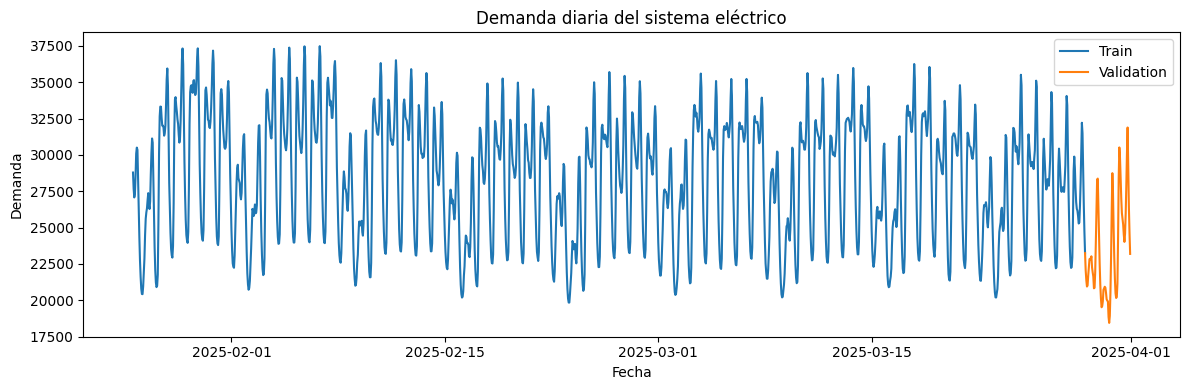

In [29]:
from statsmodels.tsa.stattools import adfuller

# Test de Dickey-Fuller
adf_result = adfuller(train['value'])
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Visualización
plt.figure(figsize=(12, 4))
plt.plot(train.index, train['value'], label='Train')
plt.plot(valid.index, valid['value'], label='Validation')
plt.legend()
plt.title('Demanda diaria del sistema eléctrico')
plt.xlabel('Fecha')
plt.ylabel('Demanda')
plt.tight_layout()
plt.show()

Con el test de Dickey-Fuller aumentado (ADF), vemos que el p-valor es menor de 0.05 y que, por lo tanto, la serie es estacionaria. Usaremos un ARMA

## ARMA

In [30]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings

warnings.filterwarnings("ignore")

# Búsqueda de hiperparámetros para ARMA
p = q = range(0, 4)
pq = list(itertools.product(p, q))

best_aic = float('inf')
best_order = None
best_model = None

for order in pq:
    try:
        model = ARIMA(train['value'], order=(order[0], 0, order[1]))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_model = results
    except:
        continue

print(f"Mejor ARMA: {best_order} con AIC = {best_aic}")

Mejor ARMA: (2, 2) con AIC = 23969.73537577306


In [31]:
arma_forecast = best_model.predict(start=valid.index[0], end=valid.index[-1])

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['value'], name='Train'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['value'], name='Validation'))
fig.add_trace(go.Scatter(x=arma_forecast.index, y=arma_forecast, name='ARMA Forecast'))
fig.update_layout(title='Predicción ARMA', template='plotly_white', hovermode='x unified')
fig.show()

El mejor ARMA tiene un p = 3 y un q = 2. Aún así, vemos que la predicción no se ajusta a la realidad de la serie en el periodo de validación. Probaremos con un ARIMA

## ARIMA

In [32]:
best_aic_arima = float('inf')
best_order_arima = None
best_model_arima = None

for order in pq:
    try:
        model = ARIMA(train['value'], order=(order[0], 1, order[1]))
        results = model.fit()
        if results.aic < best_aic_arima:
            best_aic_arima = results.aic
            best_order_arima = (order[0], 1, order[1])
            best_model_arima = results
    except:
        continue

print(f"Mejor ARIMA: {best_order_arima} con AIC = {best_aic_arima}")

Mejor ARIMA: (2, 1, 3) con AIC = 24292.083122789358


In [33]:
arima_forecast = best_model_arima.predict(start=valid.index[0], end=valid.index[-1], typ='levels')

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['value'], name='Train'))
fig.add_trace(go.Scatter(x=valid.index, y=valid['value'], name='Validation'))
fig.add_trace(go.Scatter(x=arima_forecast.index, y=arima_forecast, name='ARIMA Forecast'))
fig.update_layout(title='Predicción ARIMA', template='plotly_white', hovermode='x unified')
fig.show()

Vemos que se ajusta mejor a la serie. Vamos a verlo más en detalle

## SARIMA

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings

warnings.filterwarnings("ignore")

# Definir los rangos de hiperparámetros
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 24  # estacionalidad semanal

# Crear combinaciones de parámetros SARIMA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q))

# Inicializar variables para guardar el mejor modelo
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Grid search
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                train['value'],
                order=order,
                seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = results
        except:
            continue

# Imprimir el mejor modelo encontrado
print(f"Mejor modelo SARIMA: order={best_order}, seasonal_order={best_seasonal_order + (s,)}")
print(f"AIC: {best_aic}")

Mejor modelo SARIMA: order=(1, 1, 1), seasonal_order=(1, 1, 1, 24)
AIC: 21408.548043644296


In [36]:
import plotly.graph_objs as go

# Predecir con el mejor modelo SARIMA encontrado
sarima_forecast = best_model.predict(start=valid.index[0], end=valid.index[-1], typ='levels')

# Crear gráfico interactivo
fig = go.Figure()

# Serie de entrenamiento
fig.add_trace(go.Scatter(x=train.index, y=train['value'], mode='lines', name='Train'))

# Serie de validación
fig.add_trace(go.Scatter(x=valid.index, y=valid['value'], mode='lines', name='Validation'))

# Predicción SARIMA
fig.add_trace(go.Scatter(x=sarima_forecast.index, y=sarima_forecast, mode='lines', name='SARIMA Forecast'))

# Layout del gráfico
fig.update_layout(
    title='Predicción con modelo SARIMA optimizado',
    xaxis_title='Fecha',
    yaxis_title='Demanda',
    legend_title='Series',
    template='plotly_white',
    hovermode='x unified'
)

fig.show()

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Función MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0  # evitar división por cero
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Diccionario para guardar resultados
metrics = {}

# ARMA
metrics['ARMA'] = {
    'RMSE': np.sqrt(mean_squared_error(valid['value'], arma_forecast)),
    'MAE': mean_absolute_error(valid['value'], arma_forecast),
    'MAPE': mean_absolute_percentage_error(valid['value'], arma_forecast)
}

# ARIMA
metrics['ARIMA'] = {
    'RMSE': np.sqrt(mean_squared_error(valid['value'], arima_forecast)),
    'MAE': mean_absolute_error(valid['value'], arima_forecast),
    'MAPE': mean_absolute_percentage_error(valid['value'], arima_forecast)
}

# SARIMA
metrics['SARIMA'] = {
    'RMSE': np.sqrt(mean_squared_error(valid['value'], sarima_forecast)),
    'MAE': mean_absolute_error(valid['value'], sarima_forecast),
    'MAPE': mean_absolute_percentage_error(valid['value'], sarima_forecast)
}

# Mostrar resultados
for model_name, values in metrics.items():
    print(f"--- {model_name} ---")
    for metric_name, value in values.items():
        print(f"{metric_name}: {value:.2f}")

--- ARMA ---
RMSE: 5651.44
MAE: 4859.66
MAPE: 22.54
--- ARIMA ---
RMSE: 4561.34
MAE: 3925.78
MAPE: 18.09
--- SARIMA ---
RMSE: 4795.21
MAE: 4085.45
MAPE: 18.30


# Prophet

In [43]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd

# 1. Preparar los datos
df_prophet = df_hourly.reset_index().rename(columns={'date': 'ds', 'value': 'y'})

# Quitar zona horaria de forma robusta
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'].values).tz_localize(None)

# 2. Dividir en train y validación
train_prophet = df_prophet[df_prophet['ds'] < '2025-03-29'].copy()
valid_prophet = df_prophet[df_prophet['ds'] >= '2025-03-29'].copy()

# Asegurar que tampoco haya timezone en valid (para juntar luego)
valid_prophet['ds'] = pd.to_datetime(valid_prophet['ds'].values).tz_localize(None)

In [44]:
# 3. Crear y entrenar el modelo Prophet
m = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)
m.fit(train_prophet)

19:01:37 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
import numpy as np

In [47]:
# 4. Crear fechas futuras para predecir
future = m.make_future_dataframe(periods=len(valid_prophet), freq='H')

# 5. Predecir
forecast = m.predict(future)

# 6. Unir predicciones con datos reales
forecast = forecast[['ds', 'yhat']].set_index('ds')
results = forecast.join(valid_prophet.set_index('ds'), how='right')

# 7. Evaluar predicción
rmse = np.sqrt(mean_squared_error(results['y'], results['yhat']))
mae = mean_absolute_error(results['y'], results['yhat'])

print(f'🔮 Prophet RMSE: {rmse:.2f}')
print(f'🔮 Prophet MAE: {mae:.2f}')

🔮 Prophet RMSE: 3726.89
🔮 Prophet MAE: 3060.32


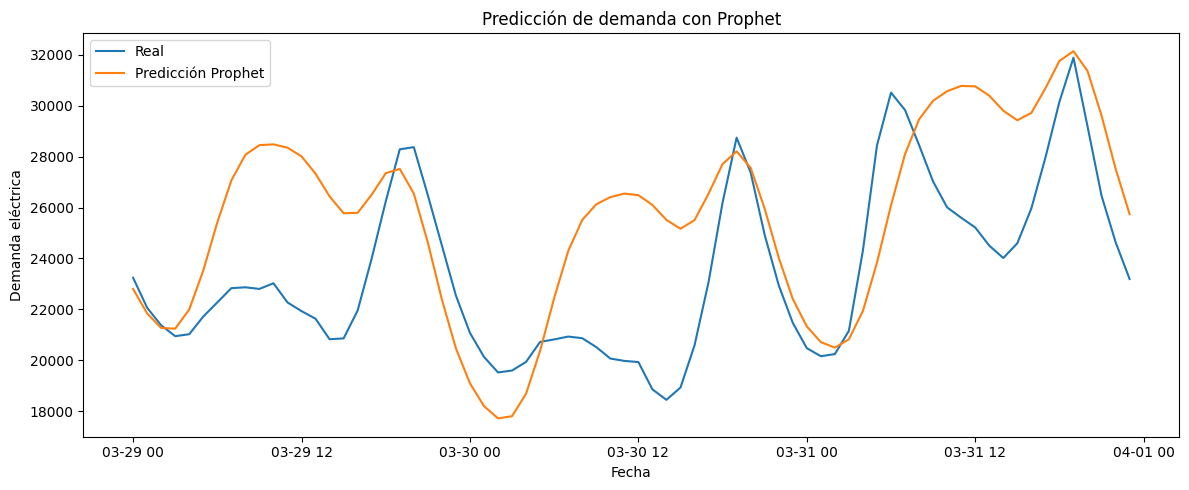

In [48]:
# 8. Visualizar resultados
plt.figure(figsize=(12,5))
plt.plot(results.index, results['y'], label='Real')
plt.plot(results.index, results['yhat'], label='Predicción Prophet')
plt.title('Predicción de demanda con Prophet')
plt.xlabel('Fecha')
plt.ylabel('Demanda eléctrica')
plt.legend()
plt.tight_layout()
plt.show()